# FNG-ITER streaming benchmark analysis 
*FNG-str* is a high quality neutronics experiment conducted on a shield mockup for iter [1]. \
Neutronics code results are compared to the experiment measurements. \
Measurements include:
- Flux evaluation via activation foil reaction rate detection
- Nuclear heating via termoluminescent detector (TLD) measures

It is worth to mention that the OpenMC simulation relies on the _weight windows_ variance reduction technique. A local weight windows file (with _wwinp_ extension) has been produced through a CADIS simulation in Attila4MC [2].

Model, experimental results and MCNP results were provided by the SINBAD repository [3].

In [1]:
import openmc_fusion_benchmarks as ofb
import matplotlib.pyplot as plt
import numpy as np

### Extract experimental and codes results from `results_database`

In [2]:
# read sinbad data
experiment_file = ofb.ResultsFromDatabase('experiment.h5', path='results_database')
mcnp_eff3_file = ofb.ResultsFromDatabase('mcnp-4a-b_eff3.h5', path='results_database')
mcnp_fendl1_file = ofb.ResultsFromDatabase('mcnp-4a-b_fendl1.h5', path='results_database')
mcnp_fendl2_file = ofb.ResultsFromDatabase('mcnp-4a-b_fendl2.h5', path='results_database')

In [3]:
# read openmc results in results_database/
openmc_fendl3_file = ofb.ResultsFromDatabase('openmc-0-14-0_fendl32b.h5', path='results_database')
openmc_endfb8_file = ofb.ResultsFromDatabase('openmc-0-14-0_endfb80.h5', path='results_database')

### Activation foils - reaction rate analysis
The following reaction rates are included:
- $^{93}Nb(n,2n)^{92m}Nb$
- $^{27}Al(n,\alpha)^{24}Na$
- $^{58}Ni(n,p)^{58}Co$
- $^{197}Au(n,\gamma)^{198}Au$

The reaction rate experiment has been repeated two times:
1) With the neutron source on axis with the streaming duct, the **_on-axis_** run, and it has two sets of foils (**_rr_onaxis1_** and **_rr_onaxis2_**)
2) With the neutron source axis shifted to the side by 5.3 cm but still parallel to the duct, the **_off-axis_** run

OpenMC evaluation of the reaction rates relies on the **_IRDFF-II_** dosimetry nuclear data library [4]. While the rest of the transport relies on the nuclear data libraries specified in the legend of the plots. A _flux multiplier_ is applied to a _track-length flux_ tally is applied on the foil _cells_.

In [4]:
# initialize reaction rate plots
foil_list = ['nb93', 'al27', 'ni58', 'au197']
reaction_labels = ['$^{93}$Nb(n,2n)$^{92m}$Nb', '$^{27}$Al(n,\u03B1)$^{24}$Na', '$^{58}$Ni(n,p)$^{58}$Co', '$^{197}$Au(n,\u03B3)$^{198}$Au']
ylabel = r'Reaction Rate $(\frac{1}{src \cdot atom})$'

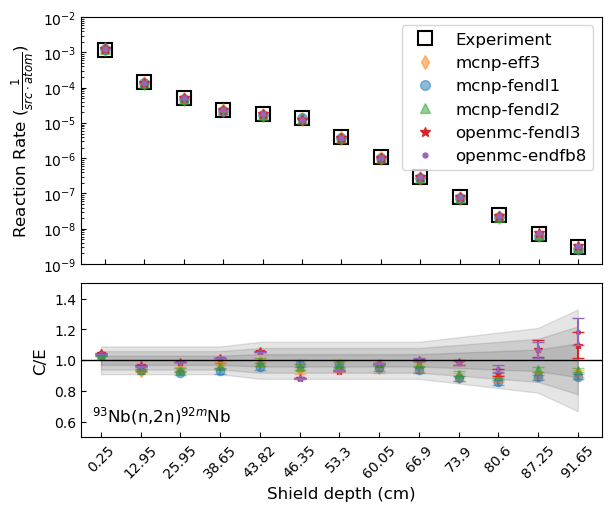

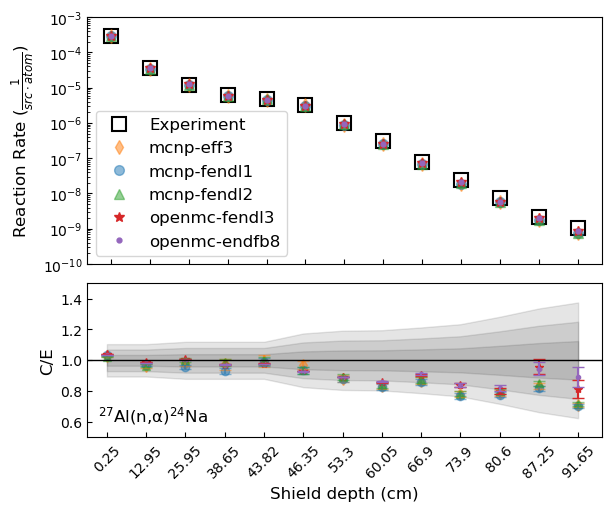

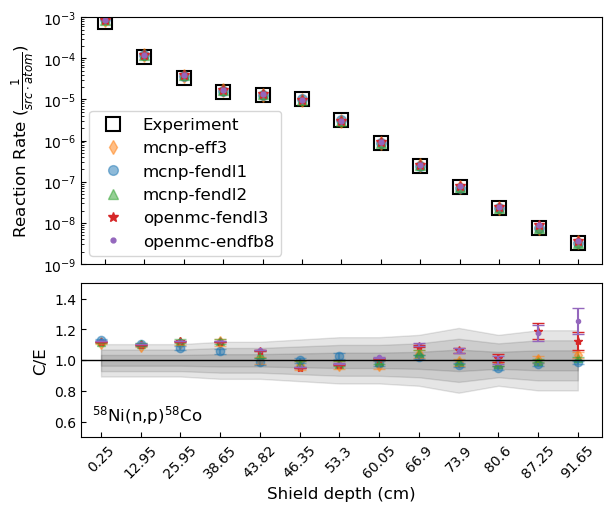

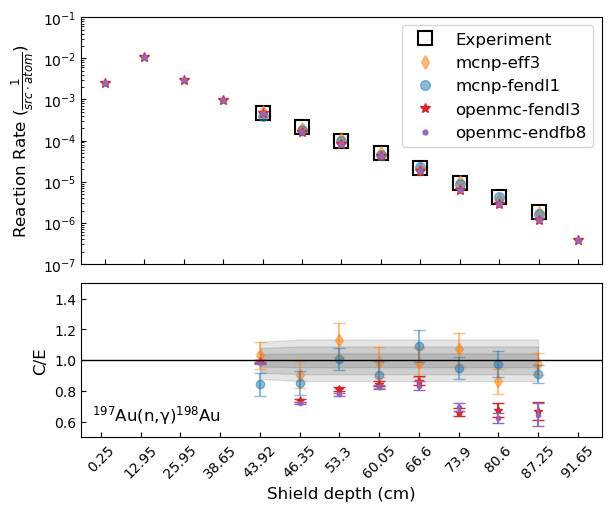

In [5]:
for i,foil in enumerate(foil_list):

    # extract tallies
    measured = experiment_file.get_tally_dataframe(f'rr_onaxis1_{foil}')
    mcnp_eff3 = mcnp_eff3_file.get_tally_dataframe(f'rr_onaxis1_{foil}')
    mcnp_fendl1 = mcnp_fendl1_file.get_tally_dataframe(f'rr_onaxis1_{foil}')
    # mcnpp-fendl2 does not have Au197 reaction rates
    try:
        mcnp_fendl2 = mcnp_fendl2_file.get_tally_dataframe(f'rr_onaxis1_{foil}')
    except:
        mcnp_fendl2 = None
    # read openmc results from its statepoint file
    openmc_fendl3 = openmc_fendl3_file.get_tally_dataframe(f'rr_onaxis1_{foil}')
    openmc_endfb8 = openmc_endfb8_file.get_tally_dataframe(f'rr_onaxis1_{foil}')
    
    # plot
    # preprocessing
    dtype_label = reaction_labels[i]
    tickers = np.arange(len(measured))
    xaxis = experiment_file.get_tally_xaxis(f'rr_onaxis1_{foil}')
    means = [measured['mean'], mcnp_eff3['mean'], mcnp_fendl1['mean'], np.array(openmc_fendl3['mean'])]

    # generate figure
    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), gridspec_kw={'height_ratios': [2, 1.25]}, constrained_layout=True)

    # plot results
    ax1.plot(tickers, measured['mean'], marker='s', ms=10, ls='none', mew=1.5, mec='k', mfc='none', label='Experiment')
    ax1.plot(tickers, mcnp_eff3['mean'], marker='d', ms=7, ls='none', color='tab:orange', alpha=0.5, label='mcnp-eff3')
    ax1.plot(tickers, mcnp_fendl1['mean'], marker='o', ms=7, ls='none', color='tab:blue', alpha=0.5, label='mcnp-fendl1')
    if mcnp_fendl2 is not None:
        ax1.plot(tickers, mcnp_fendl2['mean'], marker='^', ms=7, ls='none', color='tab:green', alpha=0.5, label='mcnp-fendl2')
    
    # openmc results
    ax1.plot(tickers, openmc_fendl3['mean'], marker='*', ms=7, ls='none', color='tab:red', label='openmc-fendl3')
    ax1.plot(tickers, openmc_fendl3['mean'], marker='.', ms=7, ls='none', color='tab:purple', label='openmc-endfb8')

    ofb.plot_stddev_area(ax=ax2, ticks=tickers, mean=np.ones(len(measured['mean'])), std_dev=measured['std. dev.']/measured['mean'])
    ax2.errorbar(tickers, mcnp_eff3['mean']/measured['mean'], mcnp_eff3['std. dev.']/measured['mean'], 
                marker='d', ms=6, capsize=4, barsabove=True, color='tab:orange', ls='none', alpha=0.5, label='_label')
    ax2.errorbar(tickers, mcnp_fendl1['mean']/measured['mean'], mcnp_fendl1['std. dev.']/measured['mean'], 
                marker='o', ms=6, capsize=4, barsabove=True, color='tab:blue', ls='none', alpha=0.5, label='_label')
    if mcnp_fendl2 is not None:
        ax2.errorbar(tickers, mcnp_fendl2['mean']/measured['mean'], mcnp_fendl2['std. dev.']/measured['mean'], 
                marker='^', ms=6, capsize=4, barsabove=True, color='tab:green', ls='none', alpha=0.5, label='_label')
    
    # openmc results
    ax2.errorbar(tickers, openmc_fendl3['mean']/measured['mean'], openmc_fendl3['std. dev.']/measured['mean'], 
                marker='*', ms=6, capsize=4, barsabove=True, color='tab:red', ls='none', label='_label')
    ax2.errorbar(tickers, openmc_endfb8['mean']/measured['mean'], openmc_endfb8['std. dev.']/measured['mean'], 
                marker='.', ms=6, capsize=4, barsabove=True, color='tab:purple', ls='none', label='_label')

    # adjust
    ofb.add_floor_ceiling(ax=ax1, values=means, scale='log', gap=0.)
    ax1.set_yscale('log')
    ax1.set_ylabel(ylabel, fontsize=12)
    ax1.set_xticks(tickers)
    ax1.tick_params(axis='x', labelbottom=False)
    ax1.tick_params(axis='both', which='both', direction='in')
    ax1.legend(fontsize=12)
    #
    ax2.hlines(1.0, -1, 20, colors='k', linestyles='-',
                linewidth=1, label='_nolegend_')
    ax2.set_xlim([-0.5, tickers[-1] + .6])
    ax2.set_ylim([0.5, 1.5])
    ax2.set_xticks(tickers)
    ax2.set_xticklabels([el.decode() for el in measured[xaxis]])
    ax2.tick_params(axis='x', labelrotation=45)
    ax2.tick_params(axis='both', which='both', direction='in')
    ax2.set_xlabel(xaxis, fontsize=12)
    ax2.set_ylabel('C/E', fontsize=12)
    ax2.annotate(dtype_label, [0.02, 0.07], xycoords='axes fraction',
                        horizontalalignment='left', verticalalignment='bottom', fontsize=12)
    plt.show()

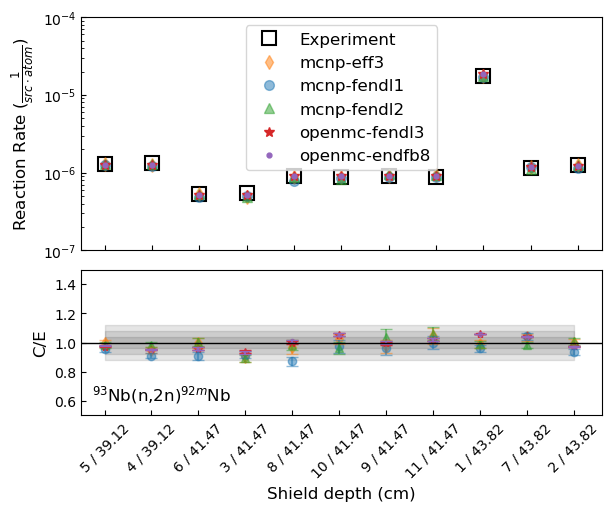

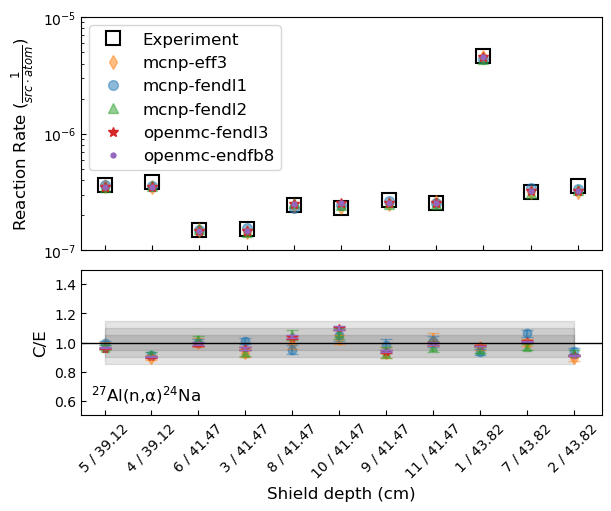

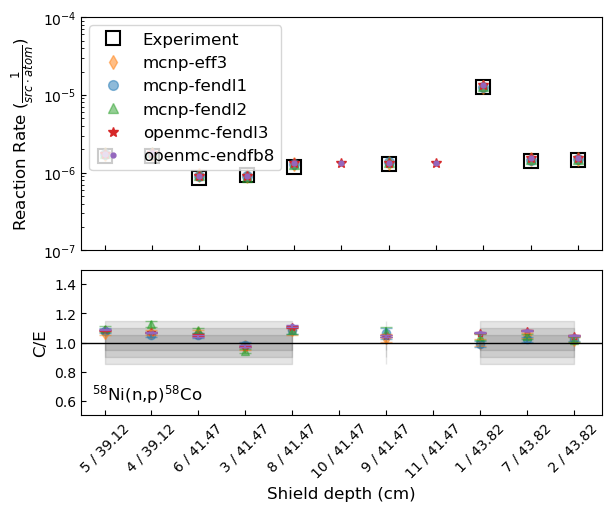

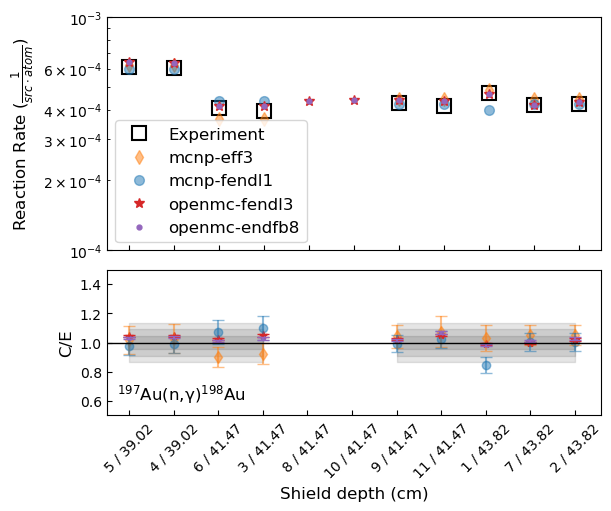

In [6]:
for i,foil in enumerate(foil_list):

    # extract tallies
    measured = experiment_file.get_tally_dataframe(f'rr_onaxis2_{foil}')
    mcnp_eff3 = mcnp_eff3_file.get_tally_dataframe(f'rr_onaxis2_{foil}')
    mcnp_fendl1 = mcnp_fendl1_file.get_tally_dataframe(f'rr_onaxis2_{foil}')
    # mcnpp-fendl2 does not have Au197 reaction rates
    try:
        mcnp_fendl2 = mcnp_fendl2_file.get_tally_dataframe(f'rr_onaxis2_{foil}')
    except:
        mcnp_fendl2 = None
    # read openmc results from its statepoint file
    openmc_fendl3 = openmc_fendl3_file.get_tally_dataframe(f'rr_onaxis2_{foil}')
    openmc_endfb8 = openmc_endfb8_file.get_tally_dataframe(f'rr_onaxis2_{foil}')
    
    # plot
    # preprocessing
    dtype_label = reaction_labels[i]
    tickers = np.arange(len(measured))
    xaxis = experiment_file.get_tally_xaxis(f'rr_onaxis2_{foil}')
    means = [measured['mean'], mcnp_eff3['mean'], mcnp_fendl1['mean'], np.array(openmc_fendl3['mean'])]

    # generate figure
    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), gridspec_kw={'height_ratios': [2, 1.25]}, constrained_layout=True)

    # plot results
    ax1.plot(tickers, measured['mean'], marker='s', ms=10, ls='none', mew=1.5, mec='k', mfc='none', label='Experiment')
    ax1.plot(tickers, mcnp_eff3['mean'], marker='d', ms=7, ls='none', color='tab:orange', alpha=0.5, label='mcnp-eff3')
    ax1.plot(tickers, mcnp_fendl1['mean'], marker='o', ms=7, ls='none', color='tab:blue', alpha=0.5, label='mcnp-fendl1')
    if mcnp_fendl2 is not None:
        ax1.plot(tickers, mcnp_fendl2['mean'], marker='^', ms=7, ls='none', color='tab:green', alpha=0.5, label='mcnp-fendl2')
    
    # openmc results
    ax1.plot(tickers, openmc_fendl3['mean'], marker='*', ms=7, ls='none', color='tab:red', label='openmc-fendl3')
    ax1.plot(tickers, openmc_fendl3['mean'], marker='.', ms=7, ls='none', color='tab:purple', label='openmc-endfb8')

    ofb.plot_stddev_area(ax=ax2, ticks=tickers, mean=np.ones(len(measured['mean'])), std_dev=measured['std. dev.']/measured['mean'])
    ax2.errorbar(tickers, mcnp_eff3['mean']/measured['mean'], mcnp_eff3['std. dev.']/measured['mean'], 
                marker='d', ms=6, capsize=4, barsabove=True, color='tab:orange', ls='none', alpha=0.5, label='_label')
    ax2.errorbar(tickers, mcnp_fendl1['mean']/measured['mean'], mcnp_fendl1['std. dev.']/measured['mean'], 
                marker='o', ms=6, capsize=4, barsabove=True, color='tab:blue', ls='none', alpha=0.5, label='_label')
    if mcnp_fendl2 is not None:
        ax2.errorbar(tickers, mcnp_fendl2['mean']/measured['mean'], mcnp_fendl2['std. dev.']/measured['mean'], 
                marker='^', ms=6, capsize=4, barsabove=True, color='tab:green', ls='none', alpha=0.5, label='_label')
    
    # openmc results
    ax2.errorbar(tickers, openmc_fendl3['mean']/measured['mean'], openmc_fendl3['std. dev.']/measured['mean'], 
                marker='*', ms=6, capsize=4, barsabove=True, color='tab:red', ls='none', label='_label')
    ax2.errorbar(tickers, openmc_endfb8['mean']/measured['mean'], openmc_endfb8['std. dev.']/measured['mean'], 
                marker='.', ms=6, capsize=4, barsabove=True, color='tab:purple', ls='none', label='_label')

    # adjust
    ofb.add_floor_ceiling(ax=ax1, values=means, scale='log', gap=0.)
    ax1.set_yscale('log')
    ax1.set_ylabel(ylabel, fontsize=12)
    ax1.set_xticks(tickers)
    ax1.tick_params(axis='x', labelbottom=False)
    ax1.tick_params(axis='both', which='both', direction='in')
    ax1.legend(fontsize=12)
    #
    ax2.hlines(1.0, -1, 20, colors='k', linestyles='-',
                linewidth=1, label='_nolegend_')
    ax2.set_xlim([-0.5, tickers[-1] + .6])
    ax2.set_ylim([0.5, 1.5])
    ax2.set_xticks(tickers)
    ax2.set_xticklabels([el.decode() for el in measured[xaxis]])
    ax2.tick_params(axis='x', labelrotation=45)
    ax2.tick_params(axis='both', which='both', direction='in')
    ax2.set_xlabel(xaxis, fontsize=12)
    ax2.set_ylabel('C/E', fontsize=12)
    ax2.annotate(dtype_label, [0.02, 0.07], xycoords='axes fraction',
                        horizontalalignment='left', verticalalignment='bottom', fontsize=12)

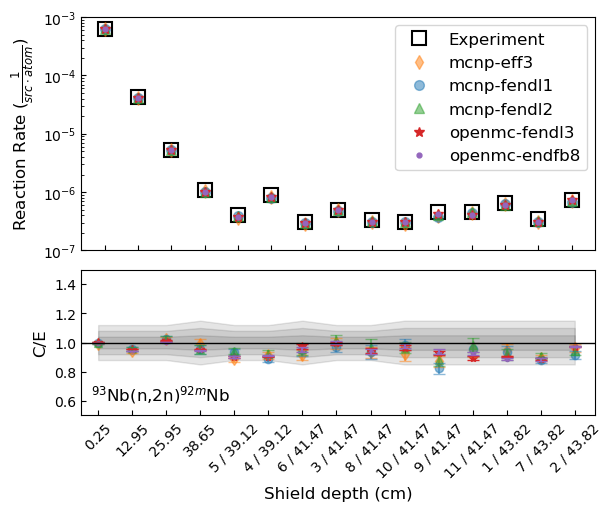

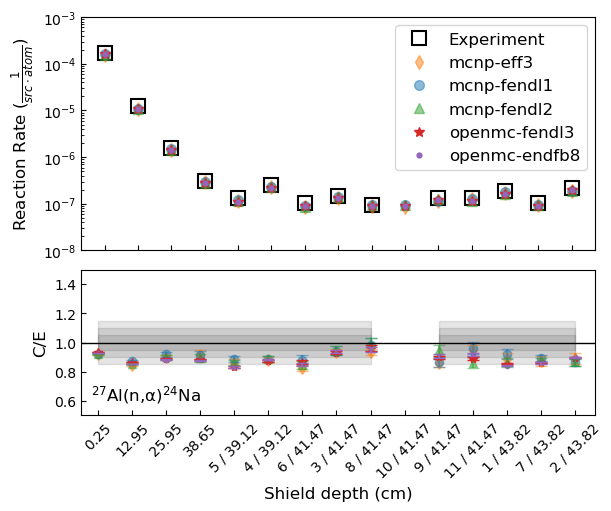

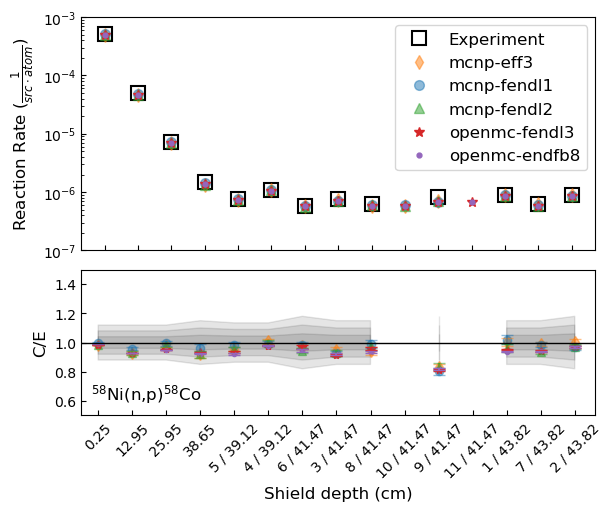

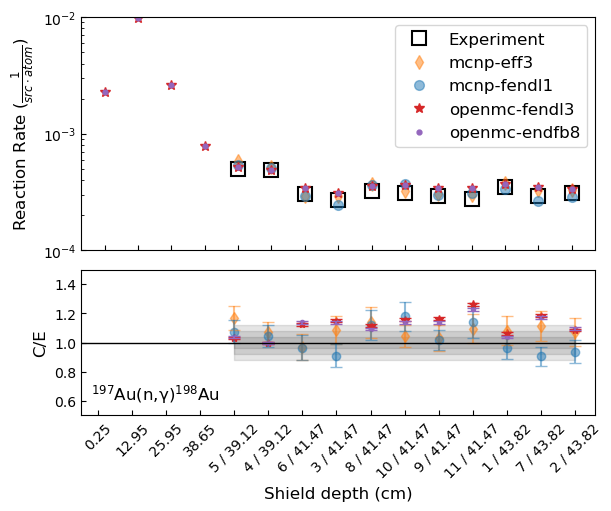

In [7]:
for i,foil in enumerate(foil_list):

    # extract tallies
    measured = experiment_file.get_tally_dataframe(f'rr_offaxis_{foil}')
    mcnp_eff3 = mcnp_eff3_file.get_tally_dataframe(f'rr_offaxis_{foil}')
    mcnp_fendl1 = mcnp_fendl1_file.get_tally_dataframe(f'rr_offaxis_{foil}')
    # mcnpp-fendl2 does not have Au197 reaction rates
    try:
        mcnp_fendl2 = mcnp_fendl2_file.get_tally_dataframe(f'rr_offaxis_{foil}')
    except:
        mcnp_fendl2 = None
    # read openmc results from its statepoint file
    openmc_fendl3 = openmc_fendl3_file.get_tally_dataframe(f'rr_offaxis_{foil}')
    openmc_endfb8 = openmc_endfb8_file.get_tally_dataframe(f'rr_offaxis_{foil}')
    
    # plot
    # preprocessing
    dtype_label = reaction_labels[i]
    tickers = np.arange(len(measured))
    xaxis = experiment_file.get_tally_xaxis(f'rr_offaxis_{foil}')
    means = [measured['mean'], mcnp_eff3['mean'], mcnp_fendl1['mean'], np.array(openmc_fendl3['mean'])]

    # generate figure
    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), gridspec_kw={'height_ratios': [2, 1.25]}, constrained_layout=True)

    # plot results
    ax1.plot(tickers, measured['mean'], marker='s', ms=10, ls='none', mew=1.5, mec='k', mfc='none', label='Experiment')
    ax1.plot(tickers, mcnp_eff3['mean'], marker='d', ms=7, ls='none', color='tab:orange', alpha=0.5, label='mcnp-eff3')
    ax1.plot(tickers, mcnp_fendl1['mean'], marker='o', ms=7, ls='none', color='tab:blue', alpha=0.5, label='mcnp-fendl1')
    if mcnp_fendl2 is not None:
        ax1.plot(tickers, mcnp_fendl2['mean'], marker='^', ms=7, ls='none', color='tab:green', alpha=0.5, label='mcnp-fendl2')
    
    # openmc results
    ax1.plot(tickers, openmc_fendl3['mean'], marker='*', ms=7, ls='none', color='tab:red', label='openmc-fendl3')
    ax1.plot(tickers, openmc_fendl3['mean'], marker='.', ms=7, ls='none', color='tab:purple', label='openmc-endfb8')

    ofb.plot_stddev_area(ax=ax2, ticks=tickers, mean=np.ones(len(measured['mean'])), std_dev=measured['std. dev.']/measured['mean'])
    ax2.errorbar(tickers, mcnp_eff3['mean']/measured['mean'], mcnp_eff3['std. dev.']/measured['mean'], 
                marker='d', ms=6, capsize=4, barsabove=True, color='tab:orange', ls='none', alpha=0.5, label='_label')
    ax2.errorbar(tickers, mcnp_fendl1['mean']/measured['mean'], mcnp_fendl1['std. dev.']/measured['mean'], 
                marker='o', ms=6, capsize=4, barsabove=True, color='tab:blue', ls='none', alpha=0.5, label='_label')
    if mcnp_fendl2 is not None:
        ax2.errorbar(tickers, mcnp_fendl2['mean']/measured['mean'], mcnp_fendl2['std. dev.']/measured['mean'], 
                marker='^', ms=6, capsize=4, barsabove=True, color='tab:green', ls='none', alpha=0.5, label='_label')
    
    # openmc results
    ax2.errorbar(tickers, openmc_fendl3['mean']/measured['mean'], openmc_fendl3['std. dev.']/measured['mean'], 
                marker='*', ms=6, capsize=4, barsabove=True, color='tab:red', ls='none', label='_label')
    ax2.errorbar(tickers, openmc_endfb8['mean']/measured['mean'], openmc_endfb8['std. dev.']/measured['mean'], 
                marker='.', ms=6, capsize=4, barsabove=True, color='tab:purple', ls='none', label='_label')

    # adjust
    ofb.add_floor_ceiling(ax=ax1, values=means, scale='log', gap=0.)
    ax1.set_yscale('log')
    ax1.set_ylabel(ylabel, fontsize=12)
    ax1.set_xticks(tickers)
    ax1.tick_params(axis='x', labelbottom=False)
    ax1.tick_params(axis='both', which='both', direction='in')
    ax1.legend(fontsize=12)
    #
    ax2.hlines(1.0, -1, 20, colors='k', linestyles='-',
                linewidth=1, label='_nolegend_')
    ax2.set_xlim([-0.5, tickers[-1] + .6])
    ax2.set_ylim([0.5, 1.5])
    ax2.set_xticks(tickers)
    ax2.set_xticklabels([el.decode() for el in measured[xaxis]])
    ax2.tick_params(axis='x', labelrotation=45)
    ax2.tick_params(axis='both', which='both', direction='in')
    ax2.set_xlabel(xaxis, fontsize=12)
    ax2.set_ylabel('C/E', fontsize=12)
    ax2.annotate(dtype_label, [0.02, 0.07], xycoords='axes fraction',
                        horizontalalignment='left', verticalalignment='bottom', fontsize=12)

We carried out a sensitivity analysis of gold concentration in the activation foil cell ranging from 0.5% to 5% of gold volume in air. We observed a significant energy self-shielding phenomenon. The C/E values for gold reaction rates fluctuates from around 0.5 with 5% gold to about 1.5 with 0.5% gold.

### Thermoluminescent detectors - nuclear heating analysis
Nuclear heating has been measured via thermoluminescent detectors which measured the dose deposited in _Gy/src_.

For this case, the OpenMC model featuring a _heating tally_ required _photon transport_ activated alongside _neutron transport_. The contributions of _neutrons_, _photons_, _electrons_ and _positrons_ have been evaluated.

To compare the tally results with the detector absorbed we take advantage of some calibration coefficients provided in SINBAD and coming from dedicated  MCNP charged particle transport modeling [3].

The deposited dose (Q) is computed as follows:

$$Q = Q_n\cdot c_n\cdot c_e + \sum(Q_i)\cdot c_p  \tag{1}$$

where $Q_n$ is the neutron contribution and $\sum(Q_i)$ is the contribution of the other particles to the nuclear heating \
$C_n$ is the ratio of the TLD/material absorbed neutron dose \
$C_p$ is the ratio of the TLD/material absorbed photon dose \
$C_e$ is the TLD neutron dose efficiency with respect to the photon dose efficiency, taken from published data and weighted over the neutron spectra

This process is done in the `helpers` and it is automated in the `run_and_store` script.

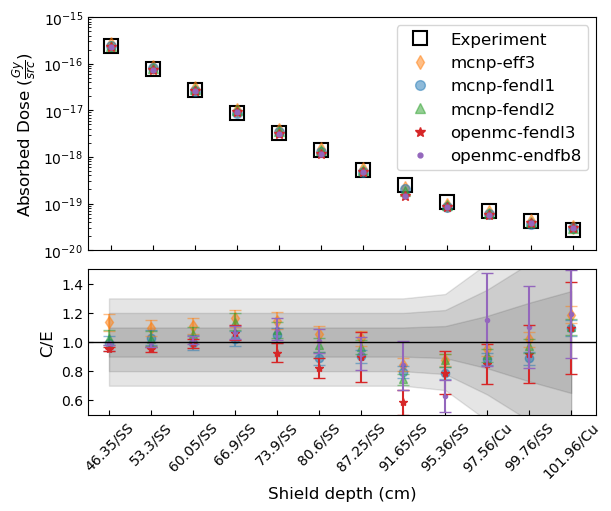

In [8]:
ylabel = r'Absorbed Dose $(\frac{Gy}{src})$'
# extract tallies
measured = experiment_file.get_tally_dataframe('nuclear_heating')
mcnp_eff3 = mcnp_eff3_file.get_tally_dataframe('nuclear_heating')
mcnp_fendl1 = mcnp_fendl1_file.get_tally_dataframe('nuclear_heating')
mcnp_fendl2 = mcnp_fendl2_file.get_tally_dataframe('nuclear_heating')
# read openmc results from its statepoint file
openmc_fendl3 = openmc_fendl3_file.get_tally_dataframe('nuclear_heating')
openmc_endfb8 = openmc_endfb8_file.get_tally_dataframe('nuclear_heating')

# plot
# preprocessing
dtype_label = reaction_labels[i]
tickers = np.arange(len(measured))
xaxis = experiment_file.get_tally_xaxis('nuclear_heating')
means = [measured['mean'], mcnp_eff3['mean'], mcnp_fendl1['mean'], mcnp_fendl2['mean']]

# generate figure
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), gridspec_kw={'height_ratios': [2, 1.25]}, constrained_layout=True)

# plot results
ax1.plot(tickers, measured['mean'], marker='s', ms=10, ls='none', mew=1.5, mec='k', mfc='none', label='Experiment')
ax1.plot(tickers, mcnp_eff3['mean'], marker='d', ms=7, ls='none', color='tab:orange', alpha=0.5, label='mcnp-eff3')
ax1.plot(tickers, mcnp_fendl1['mean'], marker='o', ms=7, ls='none', color='tab:blue', alpha=0.5, label='mcnp-fendl1')
ax1.plot(tickers, mcnp_fendl2['mean'], marker='^', ms=7, ls='none', color='tab:green', alpha=0.5, label='mcnp-fendl2')

# openmc results
ax1.plot(tickers, openmc_fendl3['mean'], marker='*', ms=7, ls='none', color='tab:red', label='openmc-fendl3')
ax1.plot(tickers, openmc_fendl3['mean'], marker='.', ms=7, ls='none', color='tab:purple', label='openmc-endfb8')

ofb.plot_stddev_area(ax=ax2, ticks=tickers, mean=np.ones(len(measured['mean'])), std_dev=measured['std. dev.']/measured['mean'])
ax2.errorbar(tickers, mcnp_eff3['mean']/measured['mean'], mcnp_eff3['std. dev.']/measured['mean'], 
            marker='d', ms=6, capsize=4, barsabove=True, color='tab:orange', ls='none', alpha=0.5, label='_label')
ax2.errorbar(tickers, mcnp_fendl1['mean']/measured['mean'], mcnp_fendl1['std. dev.']/measured['mean'], 
            marker='o', ms=6, capsize=4, barsabove=True, color='tab:blue', ls='none', alpha=0.5, label='_label')
if mcnp_fendl2 is not None:
    ax2.errorbar(tickers, mcnp_fendl2['mean']/measured['mean'], mcnp_fendl2['std. dev.']/measured['mean'], 
            marker='^', ms=6, capsize=4, barsabove=True, color='tab:green', ls='none', alpha=0.5, label='_label')
    
# openmc results
ax2.errorbar(tickers, openmc_fendl3['mean']/measured['mean'], openmc_fendl3['std. dev.']/measured['mean'], 
            marker='*', ms=6, capsize=4, barsabove=True, color='tab:red', ls='none', label='_label')
ax2.errorbar(tickers, openmc_endfb8['mean']/measured['mean'], openmc_endfb8['std. dev.']/measured['mean'], 
            marker='.', ms=6, capsize=4, barsabove=True, color='tab:purple', ls='none', label='_label')

# adjust
ofb.add_floor_ceiling(ax=ax1, values=means, scale='log', gap=0.)
ax1.set_yscale('log')
ax1.set_ylabel(ylabel, fontsize=12)
ax1.set_xticks(tickers)
ax1.tick_params(axis='x', labelbottom=False)
ax1.tick_params(axis='both', which='both', direction='in')
ax1.legend(fontsize=12)
#
ax2.hlines(1.0, -1, 20, colors='k', linestyles='-',
            linewidth=1, label='_nolegend_')
ax2.set_xlim([-0.5, tickers[-1] + .6])
ax2.set_ylim([0.5, 1.5])
ax2.set_xticks(tickers)
ax2.set_xticklabels([el.decode() for el in measured[xaxis]])
ax2.tick_params(axis='x', labelrotation=45)
ax2.tick_params(axis='both', which='both', direction='in')
ax2.set_xlabel(xaxis, fontsize=12)
ax2.set_ylabel('C/E', fontsize=12)

plt.show()

## References
[1] Angelone, M., et al. "Neutron streaming experiment at FNG: results and analysis." Fusion engineering and design 51 (2000): 653-661. https://doi.org/10.1016/S0920-3796(00)00205-2 \
[2] S. F. software, “Attila4MC” https://silverfirsoftware.com/Attila4MC.php (2023) \
[3] Kodeli, I. A., et al. "SINBAD–Radiation shielding benchmark experiments." Annals of Nuclear Energy 159 (2021): 108254. https://doi.org/10.1016/j.anucene.2021.108254 \
[4] Trkov, A., et al. "IRDFF-II: a new neutron metrology library." Nuclear Data Sheets 163 (2020): 1-108. https://doi.org/10.1016/j.nds.2019.12.001